In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
from time import time
import numpy as np
import re
import requests

import datetime as dt
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
os.getcwd()

import my_package.graph_functions as gf
import my_package.dicts as dc
import my_package.datepaths as dp
import my_package.calculus as cc
import my_package.graph_options as go

from keys import keys
import twitter

# Download raw data

In [3]:
os.chdir('/home/edmz/DisplayDataCovid/Code')

In [4]:
tic = time()

address = 'https://www.data.gouv.fr/api/1/datasets/'
datasets = ['donnees-hospitalieres-relatives-a-lepidemie-de-covid-19',
            'donnees-relatives-aux-resultats-des-tests-virologiques-covid-19',
            'donnees-relatives-aux-personnes-vaccinees-contre-la-covid-19-1',
           ]
pattern = re.compile('sp-pos-quot-dep*|vacsi-a-dep*|donnees-hospitalieres-covid19*|donnees-hospitalieres-classe-age-covid19*')

# recognize the patterns in the data.gouv datasets 
for dataset in datasets:
    response = requests.get(address + dataset) # downloads all datasets 
    for resource in response.json()['resources']: # loops on the datasets
        if (pattern.match(resource['title'])) and (resource['title'] not in os.listdir('../Data/')):
    # identifies the datasets corresponding to those needed, that are not already in the Data folder
            r = requests.get(resource['url'], allow_redirects=True)
            with open('../Data/' + resource['title'], 'wb') as file:
                file.write(r.content) # save the raw data in a filea
            print(resource['url'])
            
toc = time()
time_download = -tic + toc
print(f'{time_download:.2f} seconds to download the data'
     )

0.41 seconds to download the data


# Calculate the indicators

In [5]:
tic = time()

In [6]:
# Données relatives aux résultats des tests virologiques
d_tests_1, path_temp = cc.sp_input()
d_tests_2 = cc.sp_tot_3C(d_tests_1)
d_tests_3 = cc.sp_compute(d_tests_2)
# Données hospitalières
d_hosp_1, path_temp = cc.hosp_input()
d_hosp_2 = cc.hosp_3C(d_hosp_1, keepDROM = True)
d_hosp_3 = cc.hosp_compute(d_hosp_2)
# Something with DROM (?)
#d_hosp_1, path_temp = cc.hosp_input()
#d_hosp_2 = cc.hosp_3C(d_hosp_1, True)
#d_hosp_3_DROM = cc.hosp_compute(d_hosp_2)
# Données hospitalières départementales (pas de répartition par classe d'âge)
d_hosp_dep_1, path_temp = cc.hosp_dep_input()
d_hosp_dep_2 = cc.hosp_dep_compute(d_hosp_dep_1)
# Données relatives aux personnes vaccinées (VACSI) 
d_vac_1, path_temp = cc.vac_input()
d_vac_1 = d_vac_1[(d_vac_1.dep != '20') & (d_vac_1.dep != '98') & (d_vac_1.dep != '947') & (d_vac_1.dep != '99')& (d_vac_1.dep != '00')]
d_vac_2 = cc.vac_tot_3C(d_vac_1)
d_vac_3 = cc.vac_compute(d_vac_2)

../Data/sp-pos-quot-dep-2021-08-01-19h08.csv
../Data/donnees-hospitalieres-classe-age-covid19-2021-08-01-19h08.csv
../Data/donnees-hospitalieres-covid19-2021-08-01-19h08.csv
../Data/vacsi-a-dep-2021-07-30-19h09.csv


## Merge in one dataframe

In [7]:
dtes = d_tests_3
dvac = d_vac_3
dhos = d_hosp_3
dhosdep = d_hosp_dep_2
dhosdep['three_class'] = 'whole'

df = pd.merge(dhos, dhosdep, how = 'outer')
df = pd.merge(df, dvac, how = 'outer')
df = pd.merge(df, dtes, how = 'outer')
df = df.sort_values(['entity', 'three_class', 'jour'])

df.columns

Index(['entity', 'three_class', 'jour', 'hosp', 'rea', 'dc', 'dc hebdo',
       'taux hosp', 'taux rea', 'taux décès', 'HospConv', 'SSR_USLD', 'autres',
       'rad', 'n_dose1', 'n_complet', 'n_cum_dose1', 'n_cum_complet',
       'couv_dose1', 'couv_complet', 'taux dose 1', 'taux complet', 'P', 'T',
       'pop', 'P hebdo', 'T hebdo', 'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo'],
      dtype='object')

In [8]:
df['population'] = df['pop'] 
selected_columns = ['entity', 'three_class', 'jour',
       'taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'population', 'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo']
df = df[selected_columns]

In [8]:
toc = time()
time_calculus = -tic+toc
print(f'{time_calculus:.2f} seconds to compute')

7.31 seconds to compute


# Plot curves

In [9]:
tic = time()

In [10]:
df.sample(5)

entity three_class       jour  taux hosp  taux rea  taux décès  \
88846     976       whole 2021-07-25   0.000000  0.000000         0.0   
138636     77        0-29 2021-02-04        NaN       NaN         NaN   
159541     09       30-59 2020-06-05        NaN       NaN         NaN   
165993     18        0-29 2020-09-12        NaN       NaN         NaN   
58242      40       whole 2020-03-28   2.184577  0.728192         0.0   

        taux dose 1  taux complet  population  incidence hebdo  \
88846     22.264206     15.483896    279471.0         3.578189   
138636     0.090248      0.009868    557352.0       219.430450   
159541          NaN           NaN     56230.0         0.000000   
165993          NaN           NaN     87574.0        28.547286   
58242           NaN           NaN         NaN              NaN   

        taux de positifs hebdo  taux de tests hebdo  
88846                 0.297796          1201.555796  
138636                8.269660          2653.439837  
159541                0.000000           179.619420  
165993                2.266546          1259.506246  
58242                      NaN                  NaN

In [11]:
regions = dc.regions
regions_metro = dc.regions_metro
regions_outre_mer = dc.regions_outre_mer
print(regions)
print(regions_metro)
print(regions_outre_mer)

['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Corse', 'Grand Est', 'Hauts-de-France', 'Île-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur", 'Mayotte', 'Guyane', 'La Réunion', 'Guadeloupe', 'Martinique']
['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Corse', 'Grand Est', 'Hauts-de-France', 'Île-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur"]
['Mayotte', 'Guyane', 'La Réunion', 'Guadeloupe', 'Martinique']


In [12]:
labels = ['taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo']

In [13]:
df.three_class.unique()

array(['0-29', '30-59', '60+', 'whole'], dtype=object)

## Figures Type 1

In [14]:
plt.rcParams["figure.facecolor"] = (1,1,1,1)

In [15]:
labels = ['taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo']

In [16]:
for label in labels:
    maximum = df[df.entity.isin(dc.regions_metro)][label].max()
    print(label, maximum)

taux hosp 371.78694121213346
taux rea 57.965072368935964
taux décès 53.83322348177398
taux dose 1 93.64017993439215
taux complet 89.2053574328494
incidence hebdo 1205.8950508261705
taux de positifs hebdo 25.2809993739006
taux de tests hebdo 18953.84434239962


#### Fonctions

In [17]:
def order_entities(df, entities, label, age_class):
    """
    reorders entities (regions, départements...) by descending order of the last values of
    label / age_class
    df: dataframe
    regions: list of regions
    label: one of ['taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'incidence hebdo', 'taux de positifs hebdo', 'taux de tests hebdo']
    age_class: one of ['0-29', '30-59', '60+', 'whole']
    regions_ordered: regions ordered accordingly
    """
    jour = df[df[label].notna()].jour.max()
    entities_ordered = (df[(df.jour == jour) 
                            & (df.entity.isin(entities))
                         & (df.three_class == age_class)]
                        .groupby('entity')[label]
                        .mean()
                        .sort_values(ascending = False)
                        .index
                        .tolist()) 

    return entities_ordered

## Figures normales

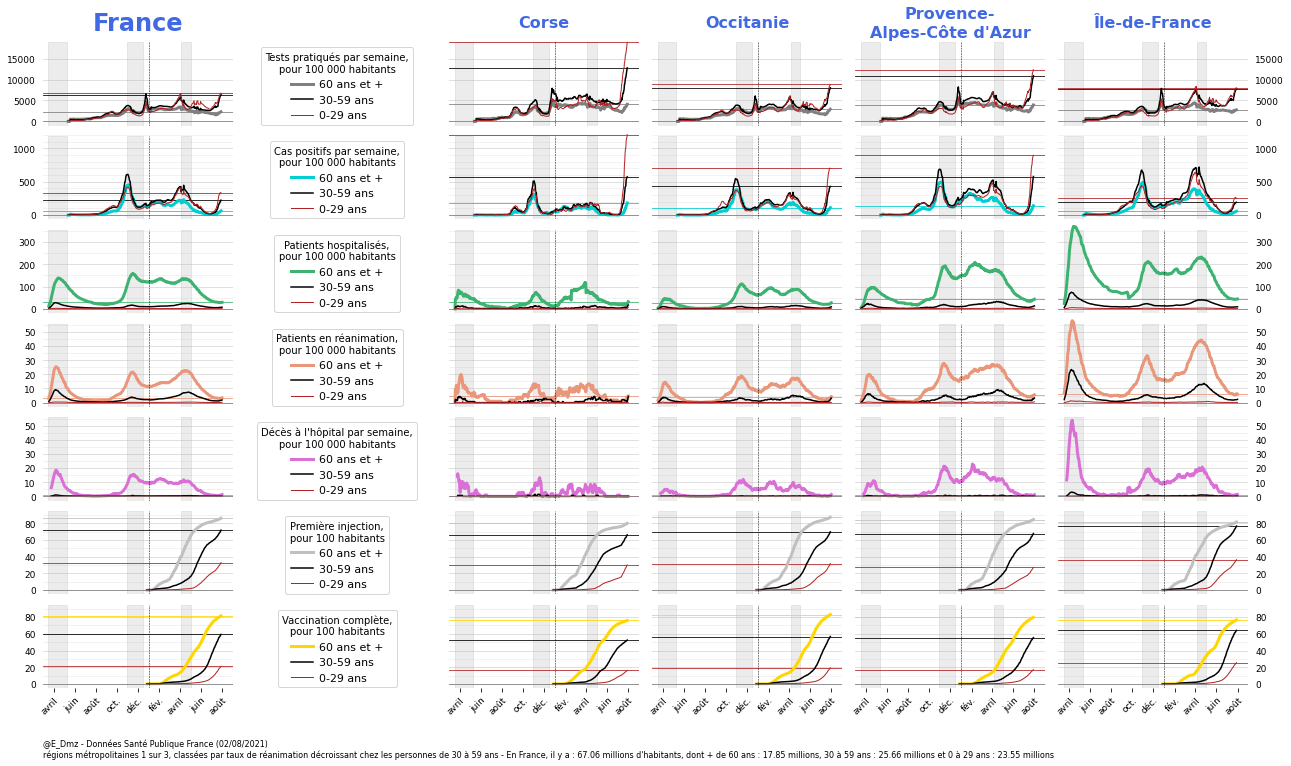

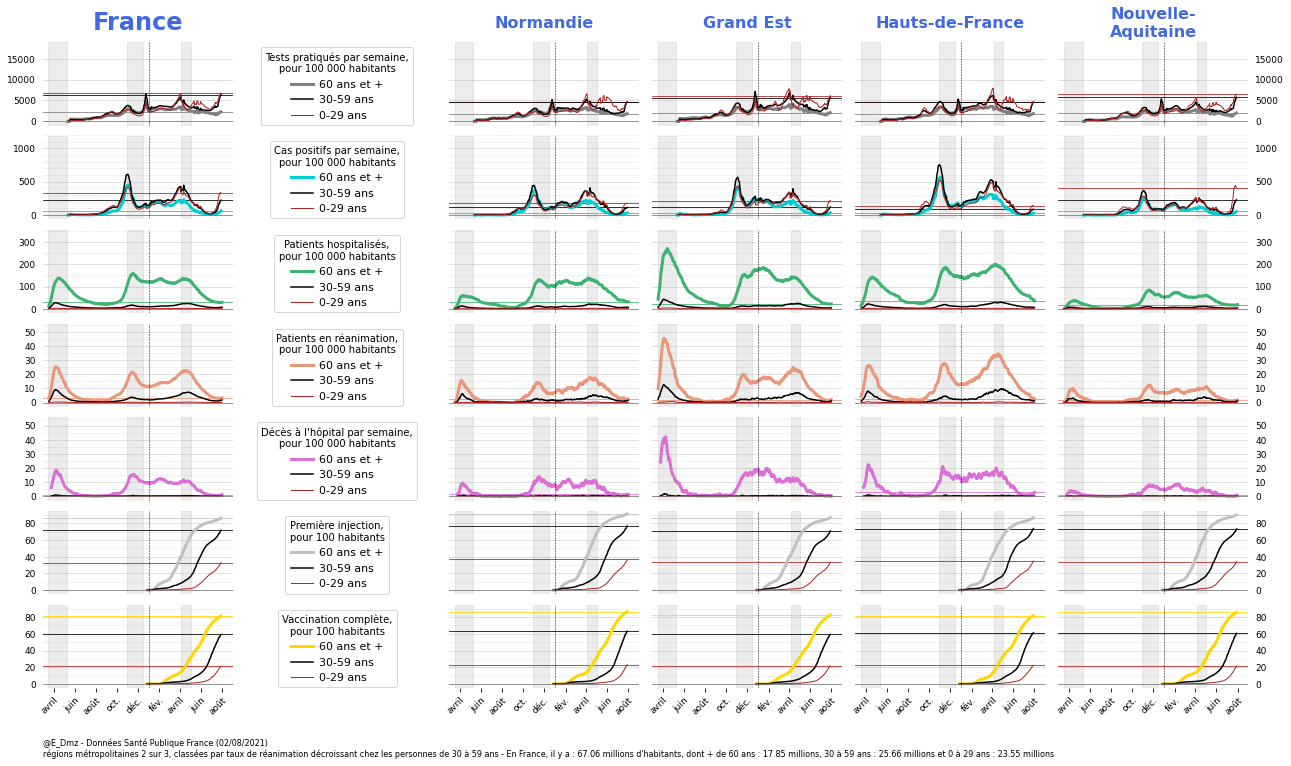

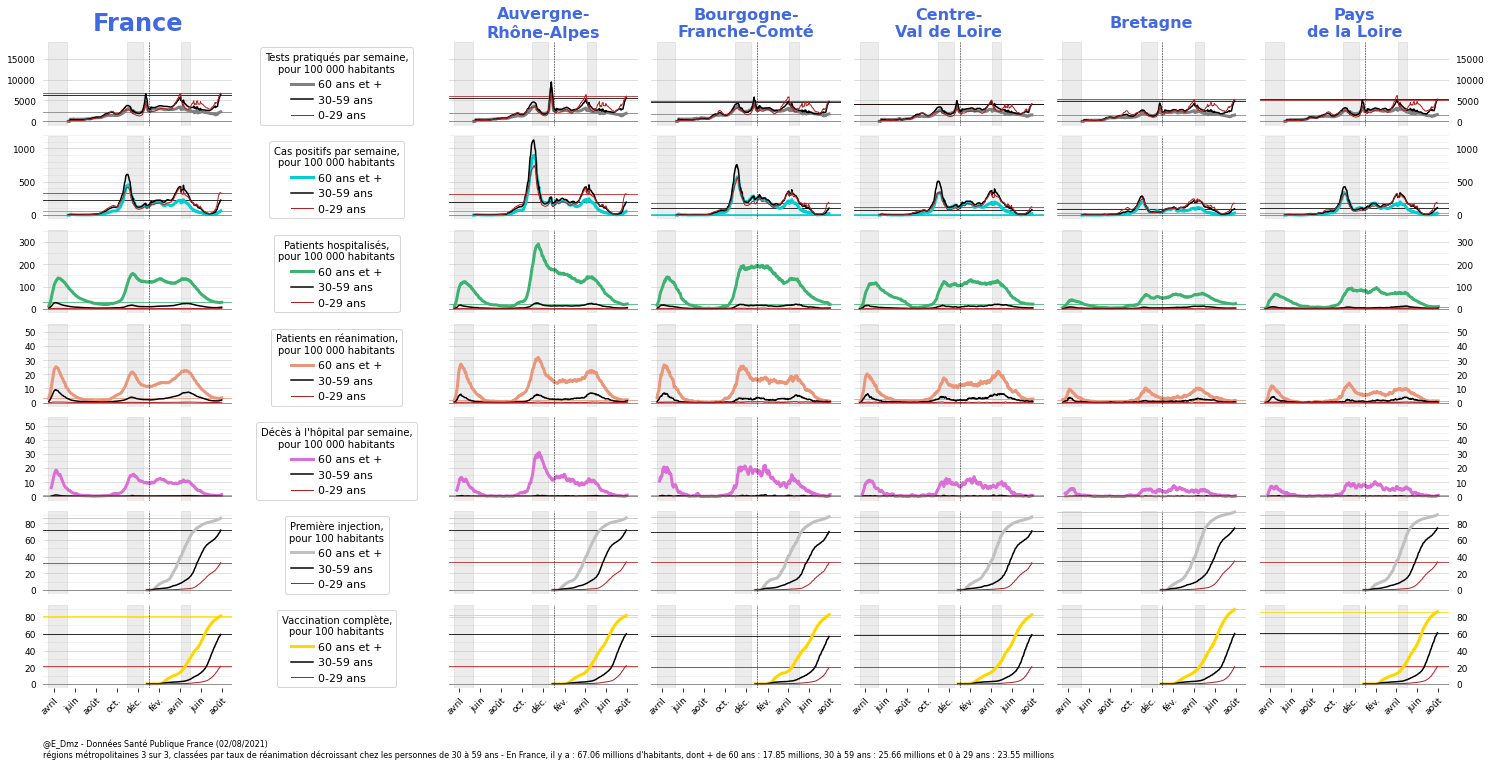

In [18]:
plt.rcParams["figure.facecolor"] = (1,1,1,1)
regions_ordered = order_entities(df, regions_metro, 'taux rea', '30-59')
title_begins = 'régions métropolitaines'
title_ends = 'classées par taux de réanimation décroissant chez les personnes de 30 à 59 ans'
graph_options = go.graph_options

gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

## Figures DROM

In [19]:
graph_options_alt_drom = go.scale_graph_by_age_class(df,regions_outre_mer, 
                         ('incidence hebdo', '30-59'),
                         ('taux de tests hebdo', '30-59'),
                         ('taux hosp', '60+'),
                         ('taux rea', '60+'),
                         ('taux décès', '60+'),
                                                     factor = 1.1
                        )

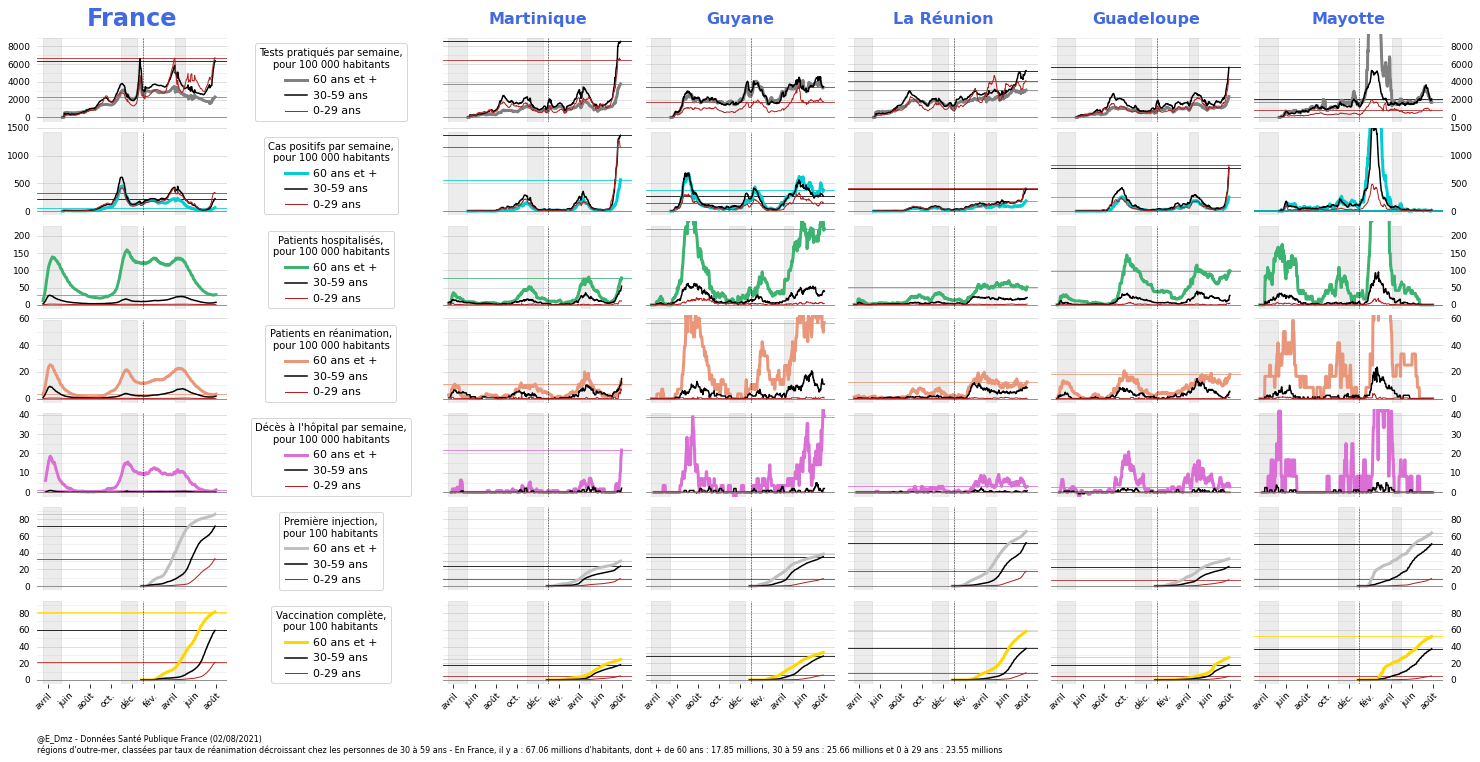

In [20]:
plt.rcParams["figure.facecolor"] = (1,1,1,1)
regions_ordered = order_entities(df, regions_outre_mer, 'taux rea', '30-59')

title_begins = 'régions d\'outre-mer'
title_ends = 'classées par taux de réanimation décroissant chez les personnes de 30 à 59 ans'

graph_options = graph_options_alt_drom

# title_begins = 'zoom régions d\'outre-mer'
gf.fig_type1(df, regions_ordered, f'{title_begins}, {title_ends}', graph_options)

### Figures zoom

In [21]:
graph_options_alt_metro = go.scale_graph_by_age_class(df, regions_metro, 
                         ('incidence hebdo', '30-59'),
                         ('taux de tests hebdo', '30-59'),
                         ('taux hosp', '60+'),
                         ('taux rea', '60+'),
                         ('taux décès', '60+'),
                                                      factor = 1.1
                        )

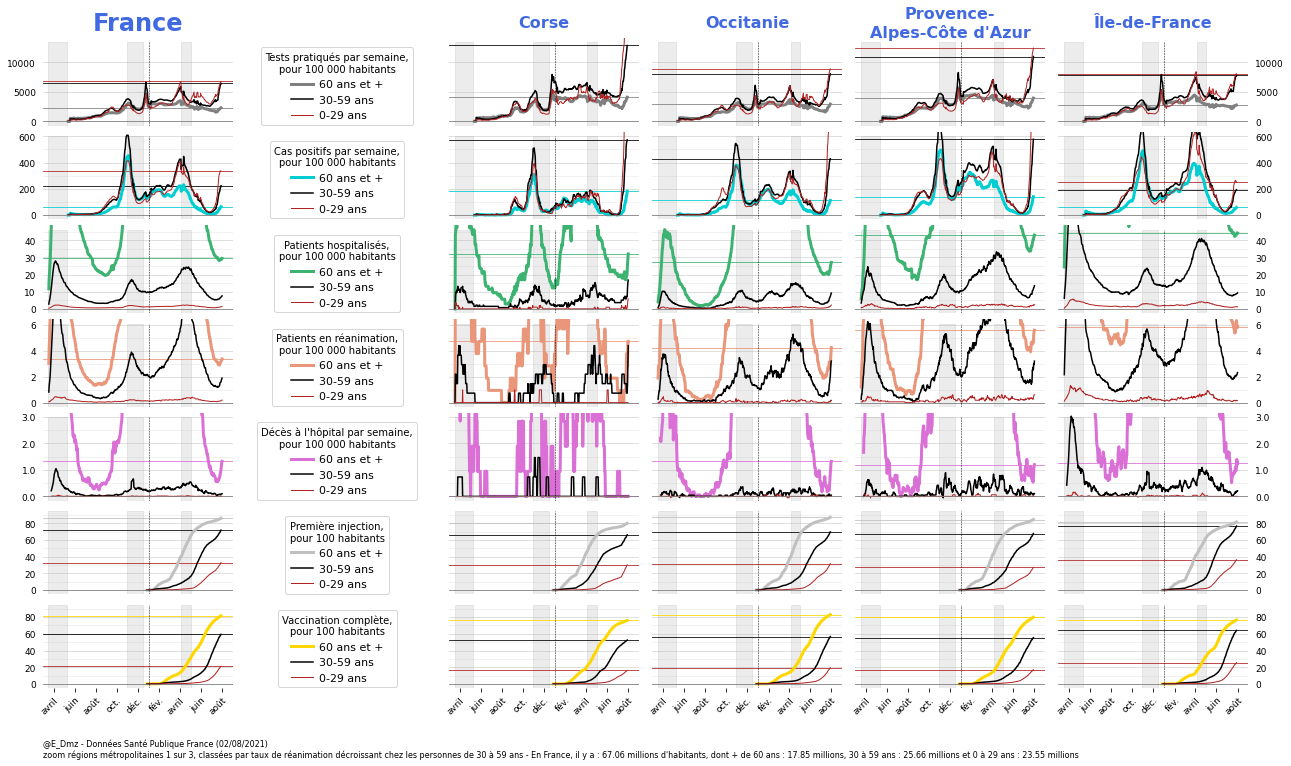

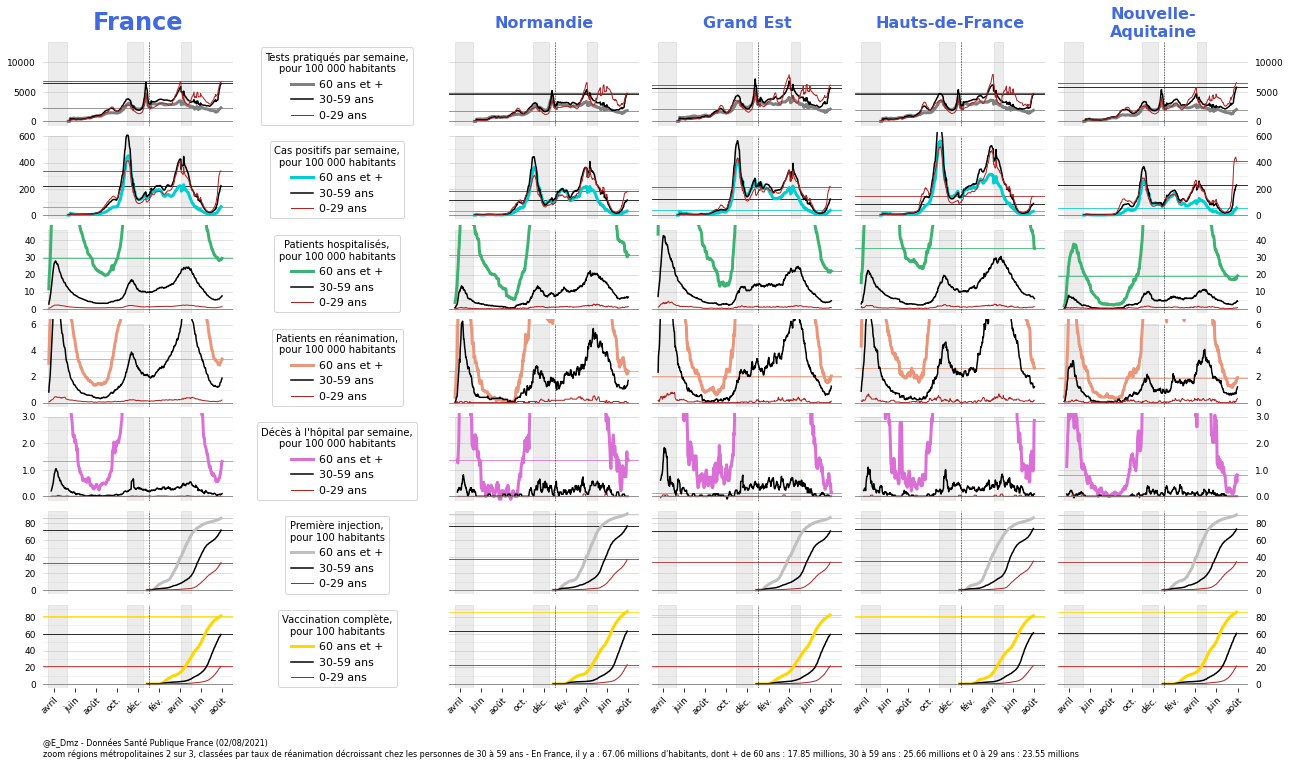

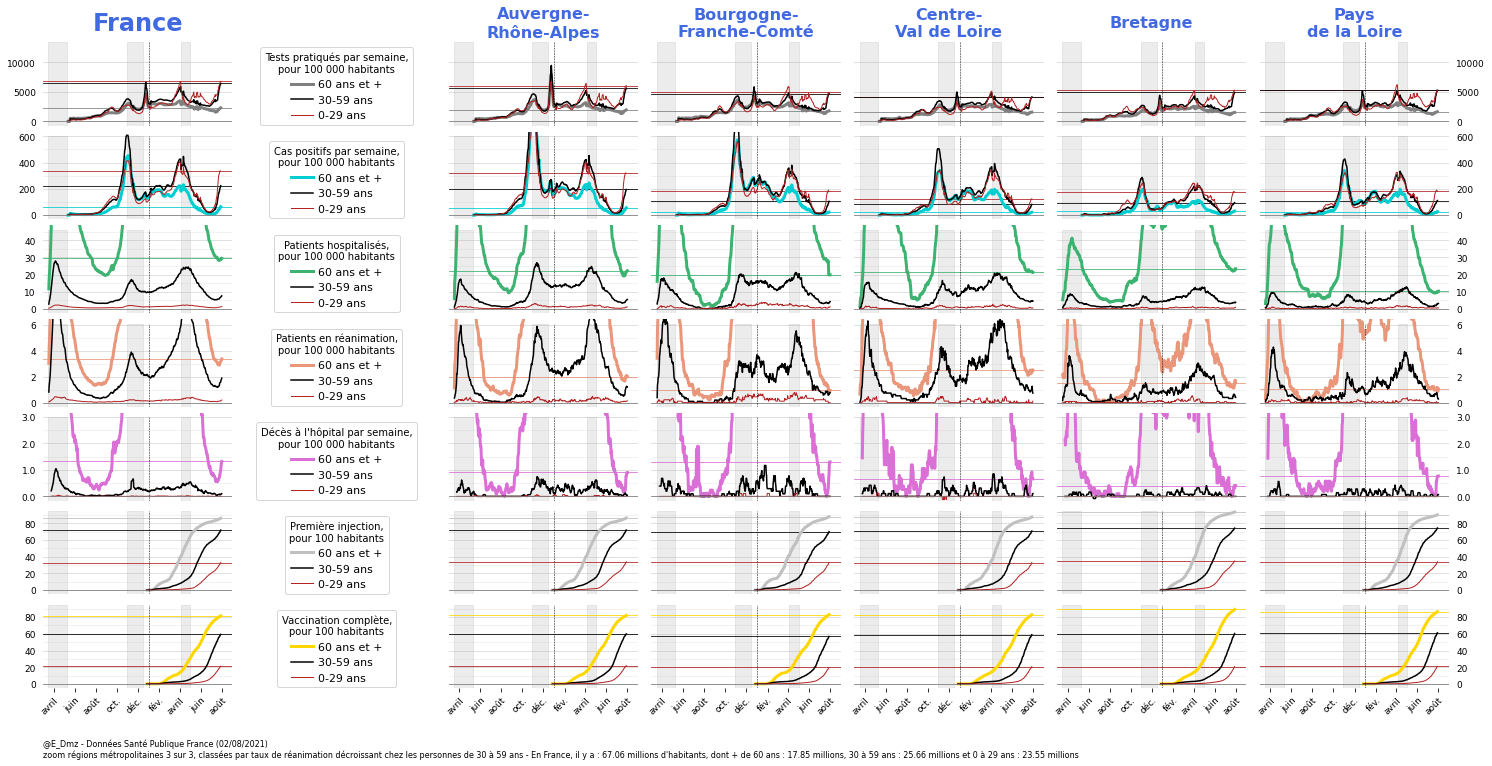

In [22]:
plt.rcParams["figure.facecolor"] = (1,1,1,1)
regions_ordered = order_entities(df, regions_metro, 'taux rea', '30-59')
title_begins = 'zoom régions métropolitaines'
title_ends = 'classées par taux de réanimation décroissant chez les personnes de 30 à 59 ans'
graph_options = graph_options_alt_metro


gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)



# # regions_ordered = order_entities(df, regions_metro, 'taux rea', '60+')
# regions_ordered = order_entities(df, regions_metro, 'incidence hebdo', '0-29')

# title_begins = 'zoom régions métropolitaines'
# title_ends = 'classées par incidence hebdomadaire décroissante chez les 0-29 ans'

# graph_options = graph_options_alt_metro

# gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
# gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
# gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

# Figures Type 0

## France et quelques régions

/home/edmz/DisplayDataCovid/Code/my_package/graph_functions.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize = (8, 4))


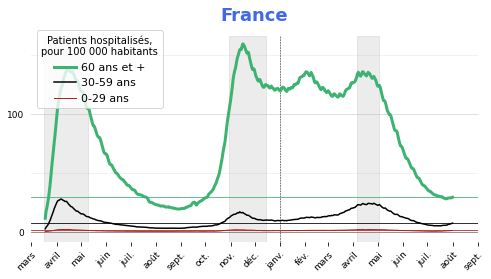

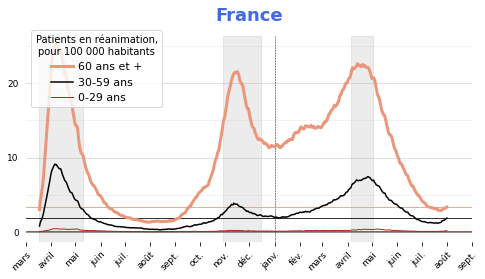

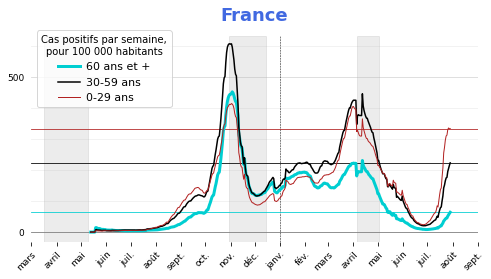

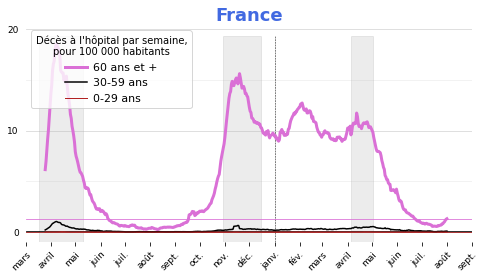

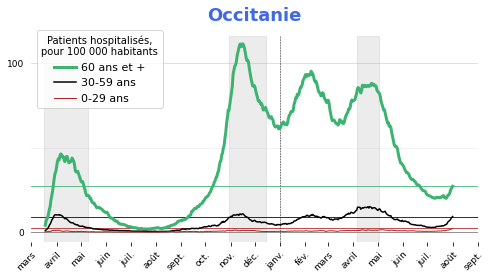

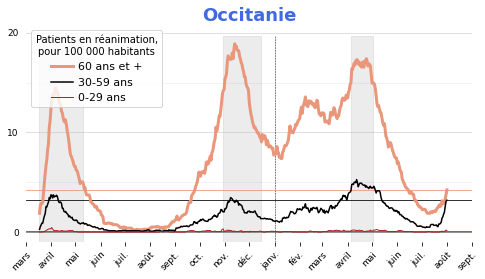

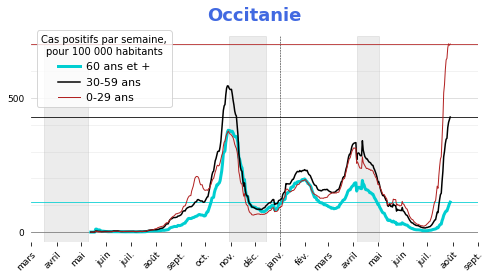

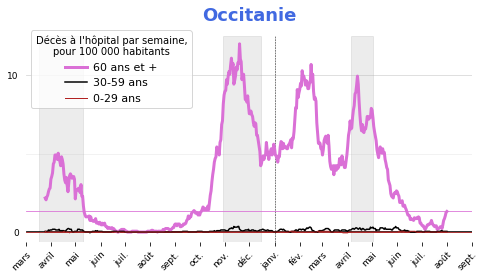

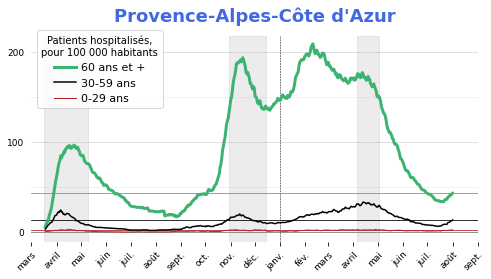

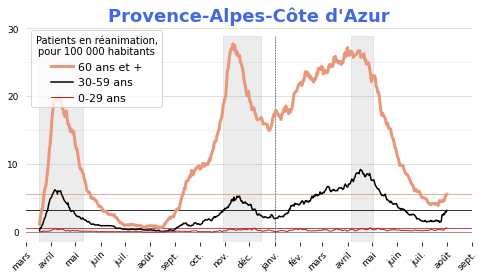

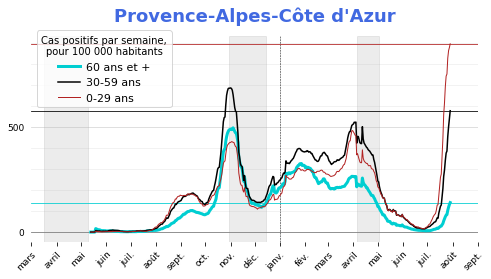

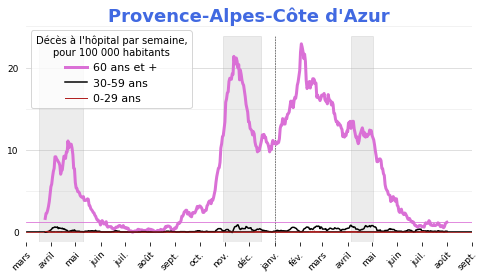

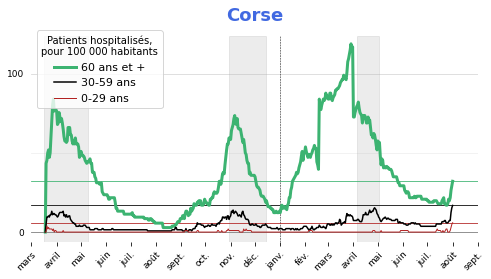

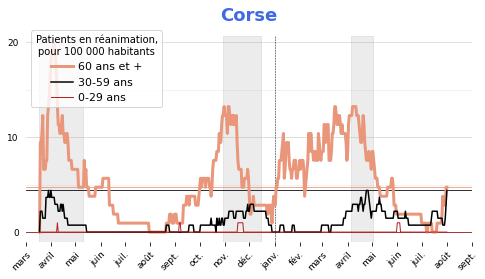

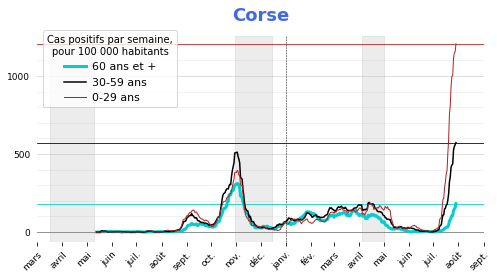

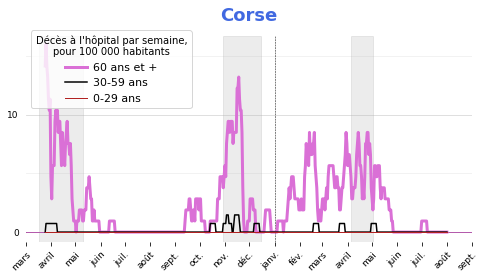

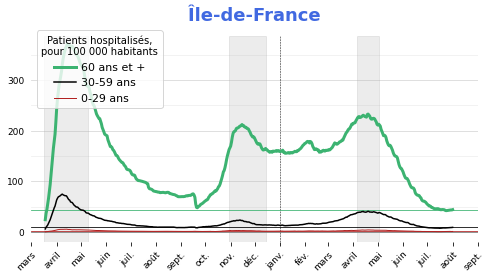

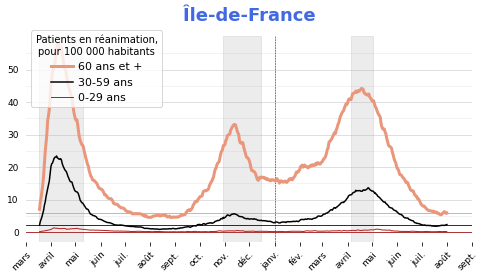

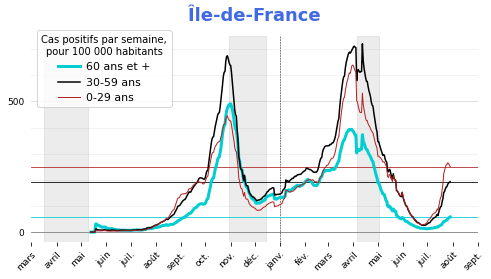

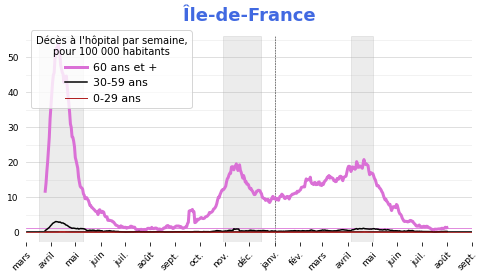

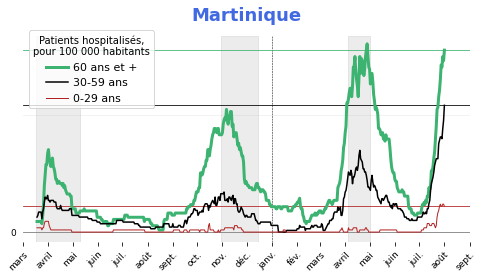

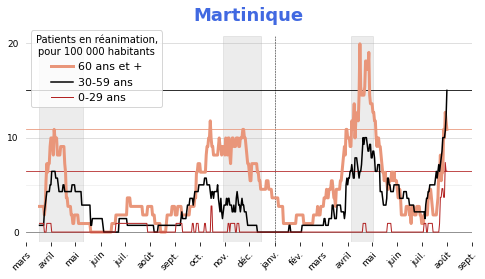

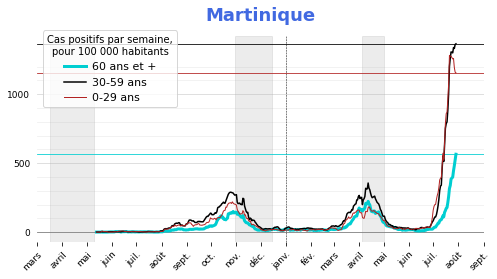

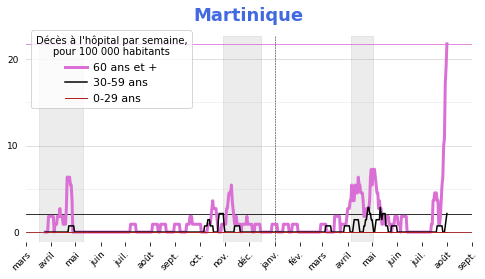

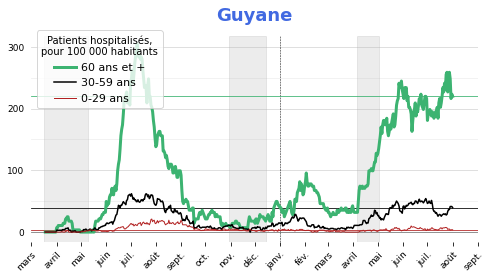

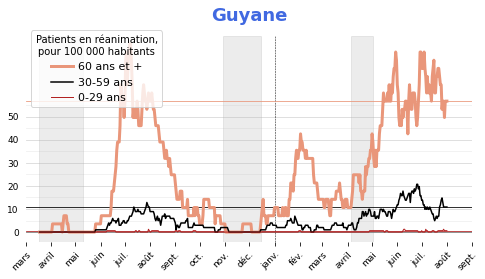

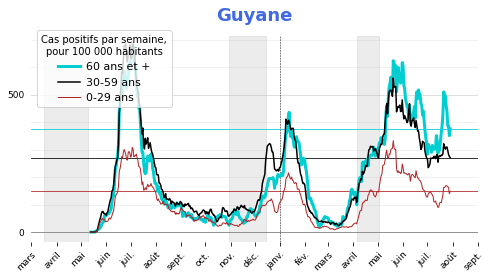

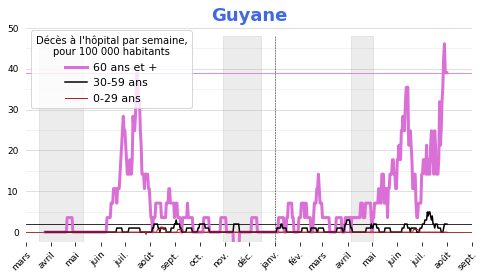

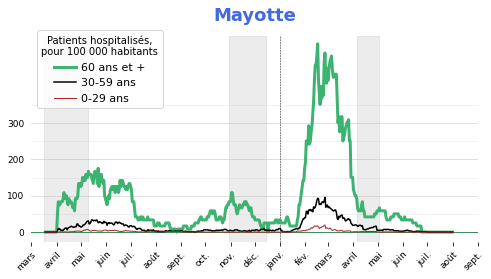

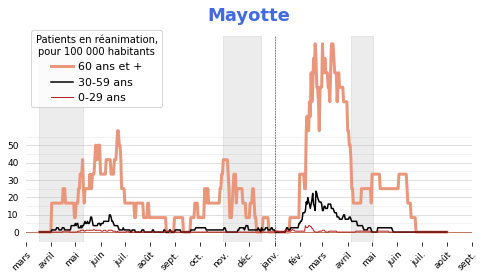

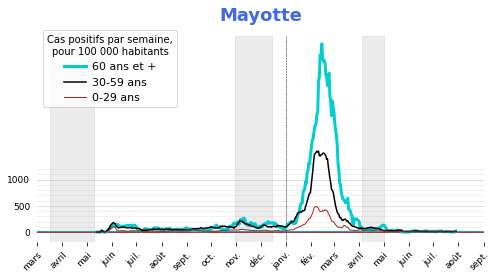

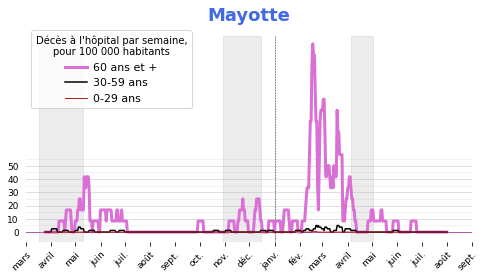

In [9]:

entities = ['France', 'Occitanie', "Provence-Alpes-Côte d'Azur", 'Corse', 'Île-de-France', 'Martinique', 'Guyane', 'Mayotte']
labels = ['taux hosp','taux rea', 'incidence hebdo', 'taux décès']

for entity in entities:
    for label in labels:
        plt.rcParams["figure.facecolor"] = (1,1,1,1)
        gf.simple_figure(df, entity, label, hline = ['0-29', '30-59', '60+'], autoscale = True)


# Tweet

In [10]:
import twitter
import my_package.tweets as tw

In [11]:
len(tw.texts)

20

In [12]:
len(tw.medias)

20

In [18]:
tweet_ends = f'\n{20}/{num_tweets}' if i == 1 else f'\n🤖 {20}/{num_tweets}'
status = api.PostUpdate(
        f'{tw.texts[19]}{tweet_ends}',
        media = tw.medias[19],
        in_reply_to_status_id = status.id,
        )

In [16]:
api = twitter.Api(**keys)
num_tweets = len(tw.texts)

for i in range(len(tw.texts)-1):
    tweet_ends = f'\n{i+1}/{num_tweets}' if i == 1 else f'\n🤖 {i+1}/{num_tweets}'
    status = api.PostUpdate(
        f'{tw.texts[i]}{tweet_ends}',
        media = tw.medias[i],
        in_reply_to_status_id = status.id,
        )
    status_0 = status if i == 0 else status_0

# #Tweet 2
# figures = ['France-incidence.png',
# 'France-hosp.png',
# 'France-rea.png',
# 'France-deces.png']
# status = api.PostUpdate(f'{tweets[1]}\n🤖 2/{num_tweets}', 
#                         media = [path_to + figure for figure in figures],
#                        in_reply_to_status_id = status.id,
#                                  )
# #Tweet 3
# figures = ['75-incidence.png',
# '92-incidence.png',
# '93-incidence.png',
# '94-incidence.png']
# status = api.PostUpdate(f'{tweets[2]}\n🤖 3/{num_tweets}', 
#                         media = [path_to + figure for figure in figures],
#                        in_reply_to_status_id = status.id,
#                                  )

# #Tweet 4
# figures = ['91-incidence.png',
# '95-incidence.png',
# '77-incidence.png',
# '78-incidence.png']
# status = api.PostUpdate(f'\n🤖 4/{num_tweets}', 
#                         media = [path_to + figure for figure in figures],
#                        in_reply_to_status_id = status.id,
#                                  )
# #Tweet 5
# path_to = path_to_type1
# figures = ['régions métropolitaines 1 sur 3.png',
# 'régions métropolitaines 2 sur 3.png',
# 'régions métropolitaines 3 sur 3.png',
# "régions d'Outre-mer.png"]
# status = api.PostUpdate(f'Comparaison de 7️⃣ indicateurs,\npour 3️⃣ classes d\'âge (0-29, 30-59 et 60+), région par région ⤵️\n(attention : échelles différentes en métropole et dans les outre-mer)\n@SantePubliqueFr @datagouvfr\n🤖 5/{num_tweets}', 
#                         media = [path_to + figure for figure in figures],
#                        in_reply_to_status_id = status.id,
#                                  )
# #Tweet 6
# figures = ['zoom régions métropolitaines 1 sur 3.png',
# 'zoom régions métropolitaines 2 sur 3.png',
# 'zoom régions métropolitaines 3 sur 3.png',
# "zoom régions d'Outre-mer.png"]
# status = api.PostUpdate(f'\n🤖 6/{num_tweets}', 
#                         media = [path_to_type1 + figure for figure in figures],
#                        in_reply_to_status_id = status.id)

# #Tweet 7

# path_to = path_to_type0
# figures = ['Guyane-incidence.png',
# 'Guyane-rea.png',
# 'Martinique-incidence.png',
# 'Martinique-rea.png']
# status = api.PostUpdate(f'\n🤖7/{num_tweets}',
#                         media = [path_to_type0 + figure for figure in figures],
#                        in_reply_to_status_id = status.id)
# #Tweet 8
# figures = ['Guyane-dose1.png',
# 'Guyane-vaccin complet.png',
# 'Martinique-dose1.png',
# 'Martinique-vaccin complet.png']
# status = api.PostUpdate(f'\n🤖8/{num_tweets}',
#                         media = [path_to_type0 + figure for figure in figures],
#                        in_reply_to_status_id = status.id)

# #Tweet 9
# toc = time()
# time_publish = -tic + toc

# status = api.PostUpdate(f'🤖 Pour faire cette MAJ, il m\'a fallu : \n{time_download:.1f} s pour télécharger, \n{time_calculus:.1f} s pour calculer,\n{time_graph:.1f} s pour tracer,\net {time_publish:.1f} s pour publier\n9/{num_tweets}',
#                        in_reply_to_status_id = status.id)

# status = api.PostRetweet(status_0.id)

# Autres graphes

In [25]:

# gf.simple_figure(d, 'Grand Est', 'taux décès')
# gf.simple_figure(d, 'Corse', 'taux complet')
# gf.simple_figure(d, 'Nouvelle-Aquitaine', 'taux rea')
# gf.simple_figure(d, 'Hauts-de-France', 'taux de tests hebdo')

In [26]:
# gf.simple_figure(d, 'France', 'taux hosp')
# gf.simple_figure(d, 'France', 'taux rea')
# gf.simple_figure(d, 'France', 'taux décès')

In [27]:
# gf.simple_figure(d, 'Mayotte', 'incidence hebdo')
# gf.simple_figure(d, 'Mayotte', 'taux rea')
# gf.simple_figure(d, '976', 'incidence hebdo')

In [28]:
def time_interval(jour = pd.Timestamp.now(), days = 1):
    period = pd.Timedelta(days, 'D')
    right = jour
    left = pd.Timestamp(jour - period)
    return pd.Interval(left, right)

time_interval()

Interval('2021-07-31 22:24:44.086465', '2021-08-01 22:24:44.086465', closed='right')

In [29]:
def last_value(df, entity, age_class, label):
    jour = df[df[label].notna()].jour.max()
    last_value = (df[(df.jour == jour) 
                    & (df.entity == entity)
                    & (df.three_class == age_class)])[label].values
    return last_value[0]

In [30]:
def max_last_value(entities, age_class, label):
    last_values = []
    for entity in entities:
        last_values.append(last_value(entity, age_class, label))
    return max(last_values)  

In [31]:
# jour = df[df['incidence hebdo'].notna()].jour.max()
# jour

# jour - pd.Timedelta(1,'D')

# df[(df.jour < jour)].jour.max()

# pd.Timestamp.now()

In [32]:
df[df.entity.isin(regions_metro)].max(axis = 0)

entity                          Île-de-France
three_class                             whole
jour                      2021-08-01 00:00:00
taux hosp                          371.786941
taux rea                            57.965072
taux décès                          53.833223
taux dose 1                          93.64018
taux complet                        89.205357
population                         12278210.0
incidence hebdo                   1205.895051
taux de positifs hebdo              25.280999
taux de tests hebdo              18953.844342
dtype: object

### Régions, échelle normale, classées par taux de réa

In [33]:
# regions_ordered = order_entities(df, regions_metro, 'taux rea', '60+')
# title_begins = 'régions métropolitaines'
# title_ends = 'classées par taux de réanimation décroissant chez les personnes de 60 ans et +'
# graph_options = go.graph_options

# gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
# gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
# gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

In [34]:
entity = '75'
age_class = '60+' 
label = 'taux complet'
d = df[ (df.entity == entity)
                    & (df.three_class == age_class) ]
last_day = d.jour.max()
d[d.jour == last_day][label].values[0]

81.64272872018728

In [35]:
d = df[ (df.entity == entity)
                    & (df.three_class == age_class) & df[label].notna()]
d

entity three_class       jour  taux hosp  taux rea  taux décès  \
137231     75         60+ 2020-12-27        NaN       NaN         NaN   
137234     75         60+ 2020-12-28        NaN       NaN         NaN   
137237     75         60+ 2020-12-29        NaN       NaN         NaN   
137240     75         60+ 2020-12-30        NaN       NaN         NaN   
137243     75         60+ 2020-12-31        NaN       NaN         NaN   
...       ...         ...        ...        ...       ...         ...   
137861     75         60+ 2021-07-25        NaN       NaN         NaN   
137864     75         60+ 2021-07-26        NaN       NaN         NaN   
137867     75         60+ 2021-07-27        NaN       NaN         NaN   
137870     75         60+ 2021-07-28        NaN       NaN         NaN   
137873     75         60+ 2021-07-29        NaN       NaN         NaN   

        taux dose 1  taux complet  population  incidence hebdo  \
137231     0.002469      0.000000    486118.0       128.981029   
137234     0.005348      0.000000    486118.0       127.746761   
137237     0.006994      0.000000    486118.0       123.632534   
137240     0.013783      0.000000    486118.0       124.455379   
137243     0.018925      0.000000    486118.0       123.426822   
...             ...           ...         ...              ...   
137861    86.737788     80.484574    486118.0        57.393472   
137864    86.943911     80.766193    486118.0        63.153391   
137867    87.214421     81.065503    486118.0        65.827639   
137870    87.456543     81.367281    486118.0        66.444773   
137873    87.712860     81.642729    486118.0        70.559000   

        taux de positifs hebdo  taux de tests hebdo  
137231                2.361671          5461.431175  
137234                2.527061          5055.151218  
137237                2.777778          4450.771212  
137240                3.132443          3973.109410  
137243                3.455624          3571.766526  
...                        ...                  ...  
137861                1.649911          3478.579275  
137864                1.761432          3585.343476  
137867                1.819422          3618.051584  
137870                1.842661          3605.914613  
137873                1.941912          3633.479937  

[215 rows x 12 columns]

In [36]:
# gf.simple_figure(d, 'Guyane', 'taux hosp')
# gf.simple_figure(d, 'Guyane', 'taux rea')
# gf.simple_figure(d, 'Guyane', 'taux décès')
# gf.simple_figure(d, '973', 'taux dose 1')
# gf.simple_figure(d, '973', 'taux complet')


In [37]:
# gf.simple_figure(d, '973', 'incidence hebdo')
# gf.simple_figure(d, '93', 'incidence hebdo')
# gf.simple_figure(d, '971', 'incidence hebdo')

# gf.simple_figure(d, '971', 'incidence hebdo')

In [38]:
# gf.simple_figure(d, 'France', 'incidence hebdo')
# gf.simple_figure(d, 'Île-de-France', 'incidence hebdo')
# gf.simple_figure(d, '75', 'incidence hebdo')


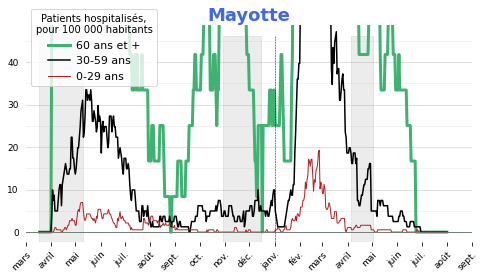

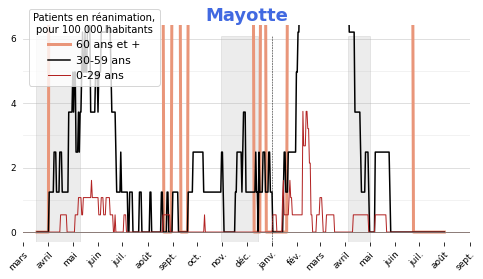

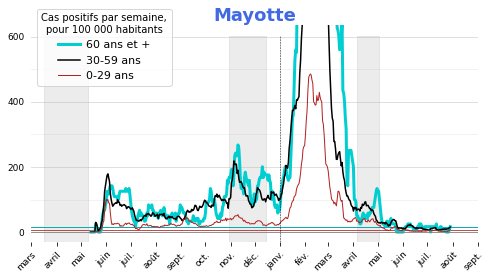

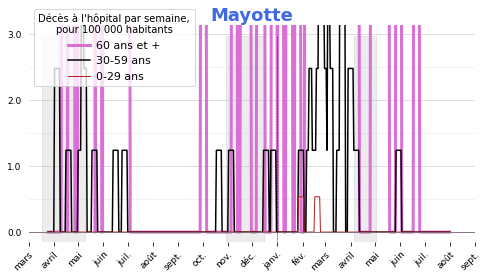

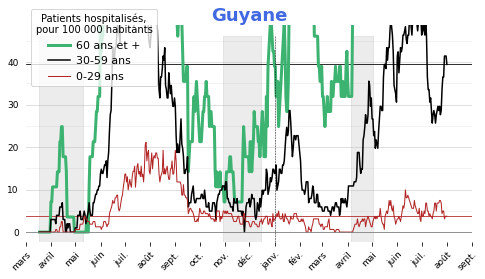

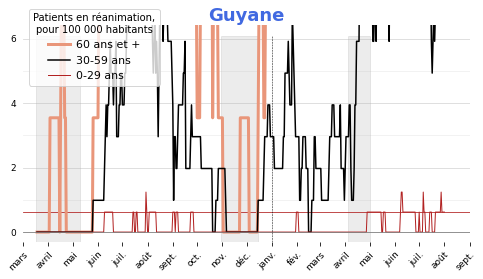

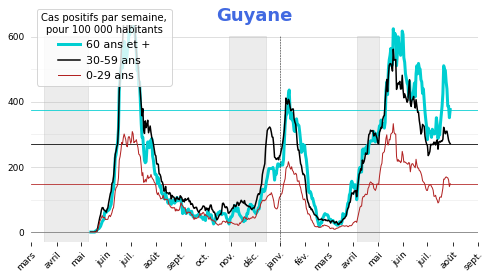

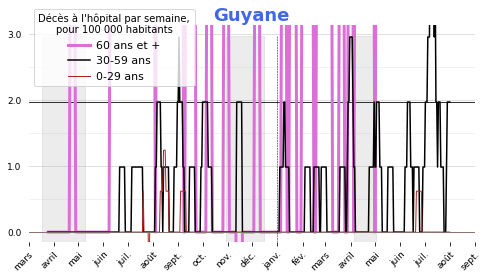

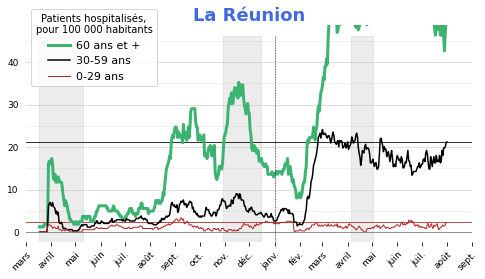

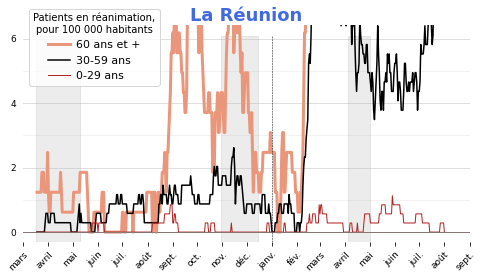

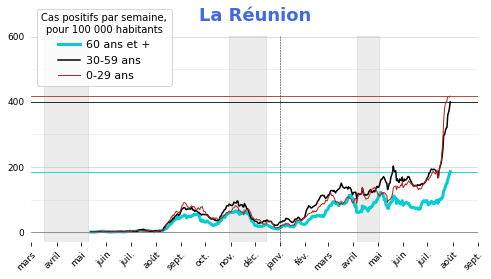

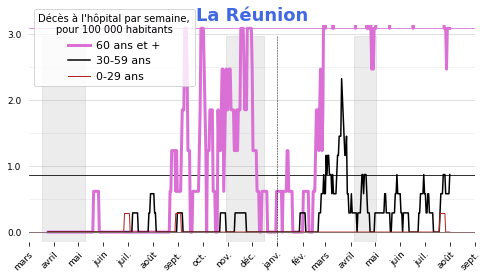

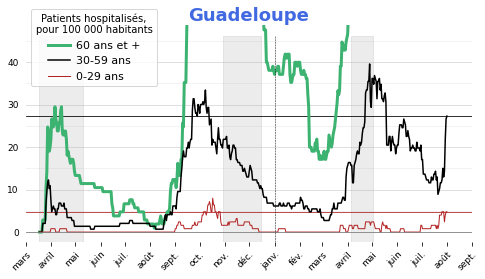

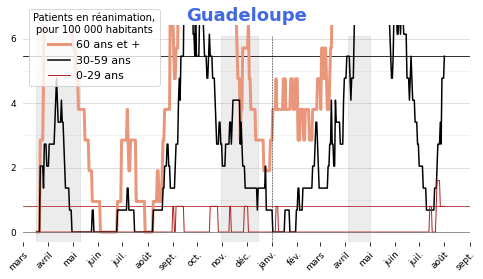

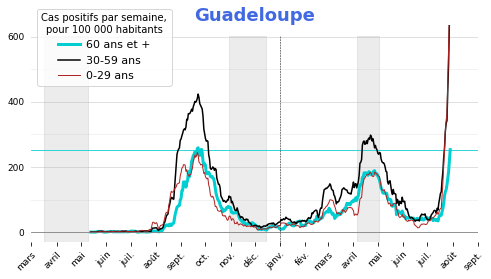

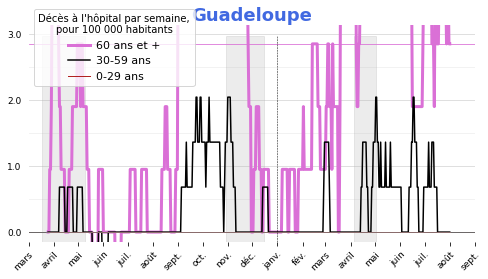

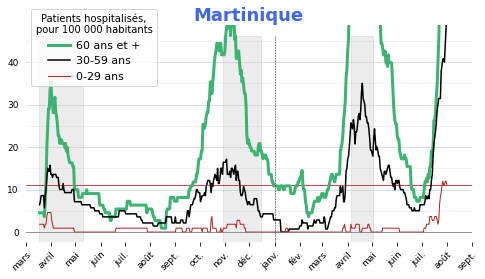

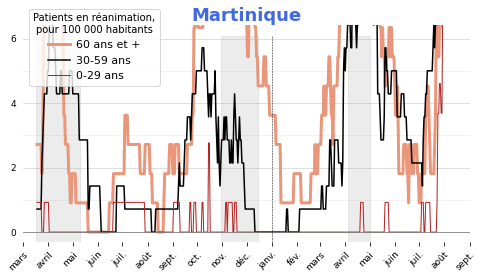

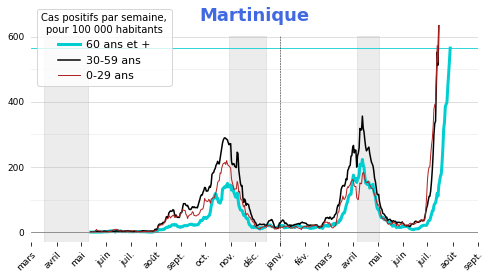

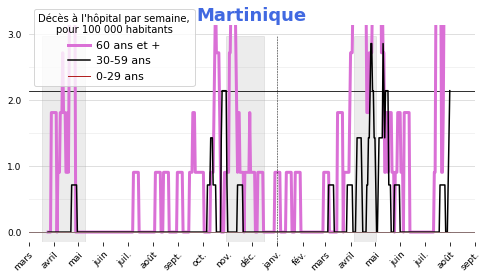

In [40]:
entities = regions_outre_mer
labels = ['taux hosp','taux rea', 'incidence hebdo', 'taux décès']
graph_options = go.graph_options

for entity in entities:
    for label in labels:
        gf.simple_figure(df, entity, label, graph_options = graph_options, hline = ['0-29', '30-59', '60+'])


In [41]:
labels

['taux hosp', 'taux rea', 'incidence hebdo', 'taux décès']

In [42]:
graph_options['taux de positifs hebdo']['ymax'] = 5

In [43]:
graph_options = go.graph_options_auto({'taux de positifs hebdo': 7.5})

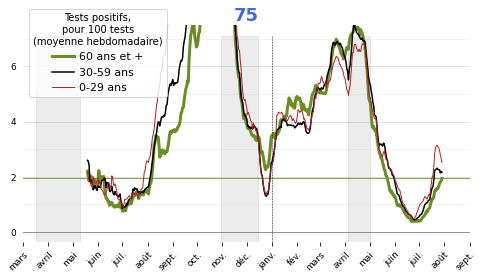

In [44]:
gf.simple_figure(df, '75', 'taux de positifs hebdo', graph_options = graph_options)

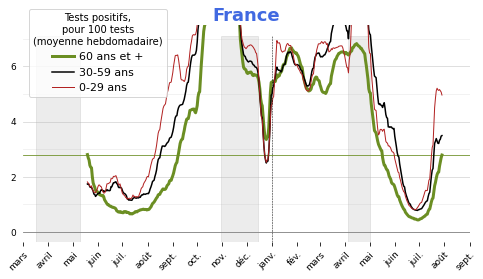

In [45]:
gf.simple_figure(df, 'France', 'taux de positifs hebdo', graph_options = graph_options)

In [46]:
graph_options = go.graph_options_auto({'taux de tests hebdo': 7500})

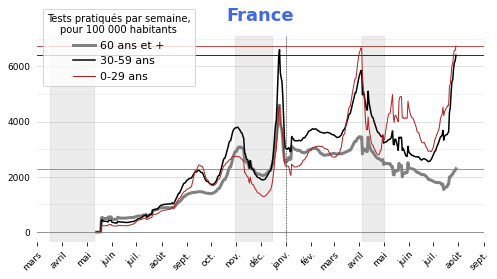

In [47]:
gf.simple_figure(df, 'France', 'taux de tests hebdo', graph_options = graph_options)

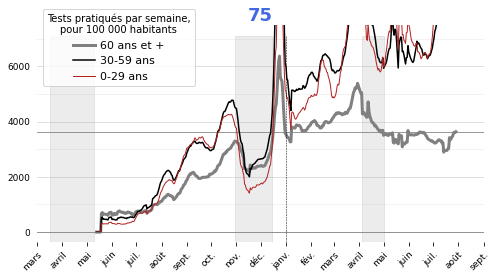

In [48]:
gf.simple_figure(df, '75', 'taux de tests hebdo', graph_options = graph_options)

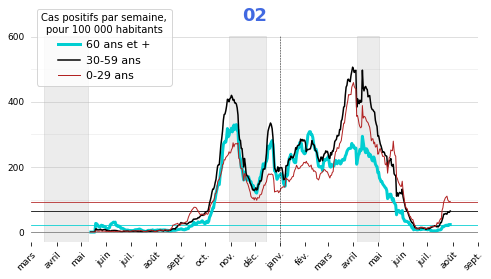

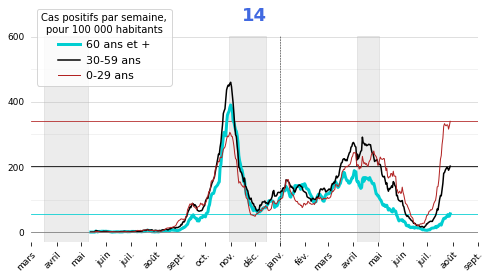

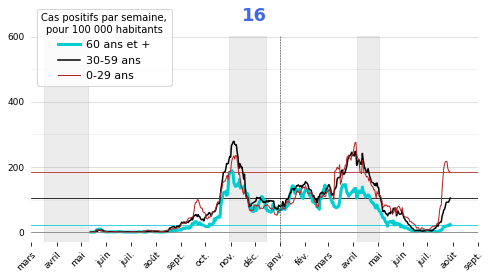

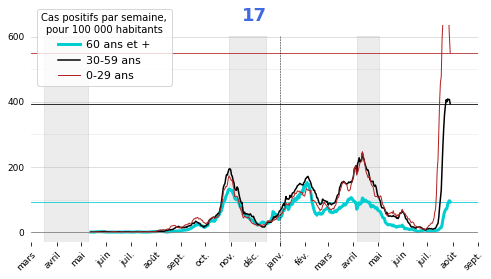

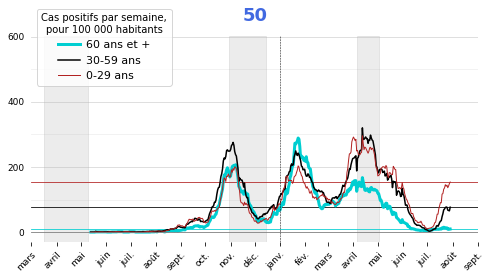

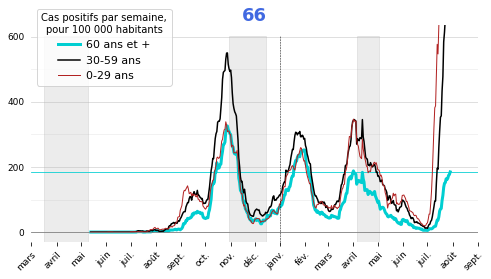

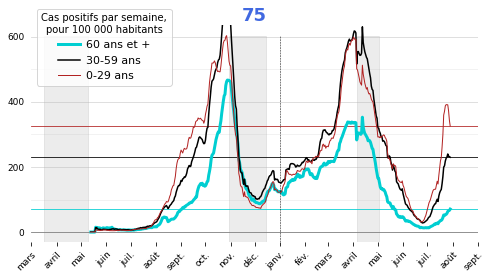

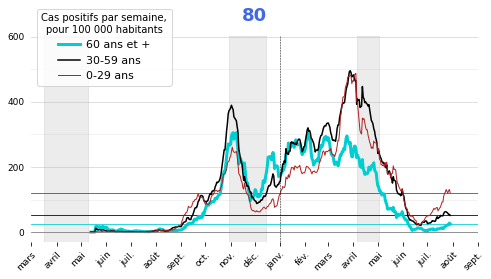

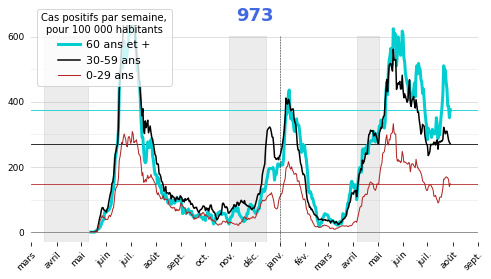

In [49]:
for entity in ['02', '14', '16', '17', '50', '66', '75', '80', '973']:
    gf.simple_figure(df, entity, 'incidence hebdo', graph_options = graph_options)

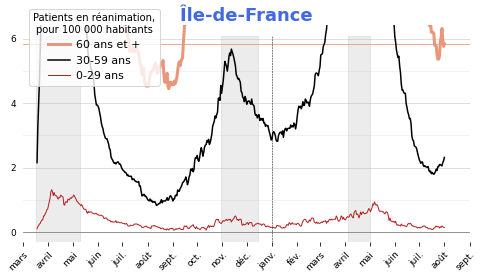

In [50]:
gf.simple_figure(df, 'Île-de-France', 'taux rea', graph_options = graph_options)

## Départements d'Île-de-France

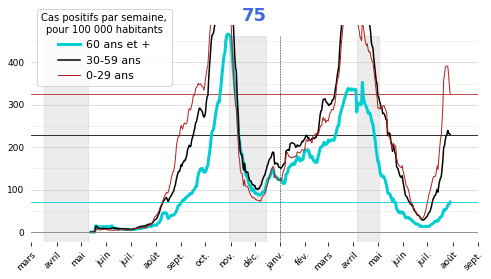

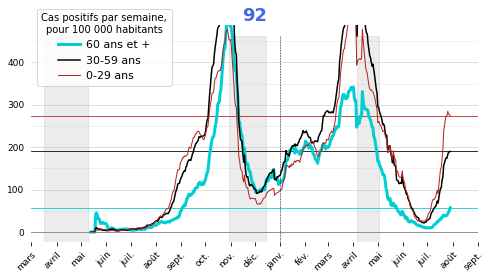

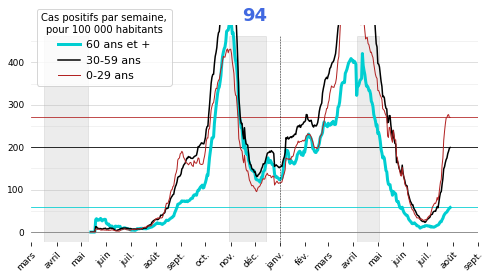

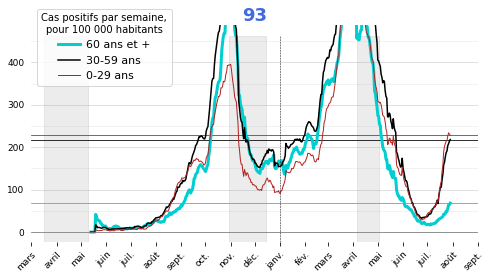

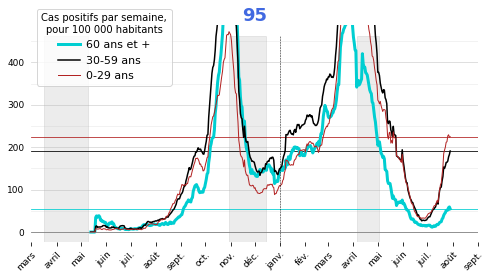

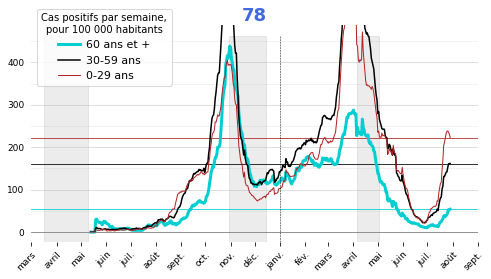

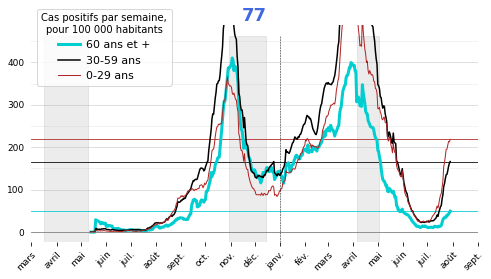

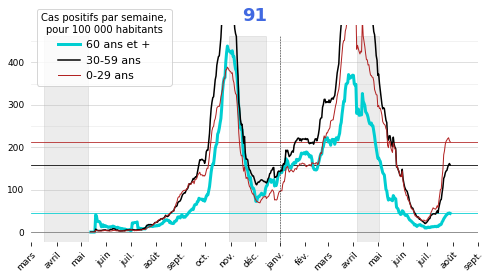

In [51]:
entities = ['75', '93', '92', '94', '91', '95', '77', '78']
graph_options = go.scale_graph_by_age_class(df, entities,
                         ('incidence hebdo', '0-29'),
                         ('taux de tests hebdo', '0-29'),
                        )


entities = order_entities(df, entities, 'incidence hebdo', '0-29')

labels = ['incidence hebdo',]

for entity in entities:
    for label in labels:
        gf.simple_figure(df, entity, label, graph_options = graph_options)

## Martinique et Guyane

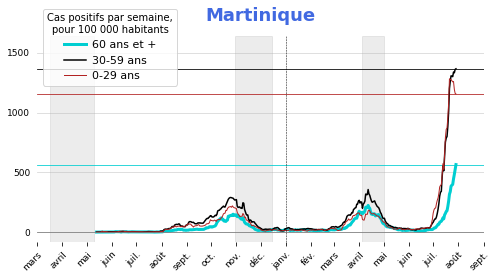

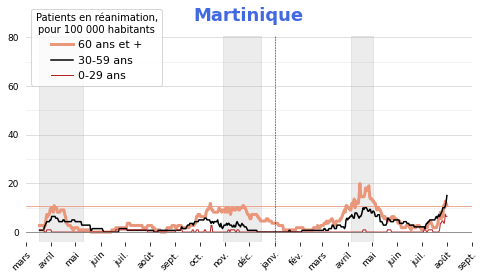

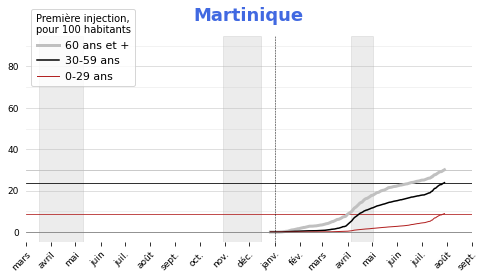

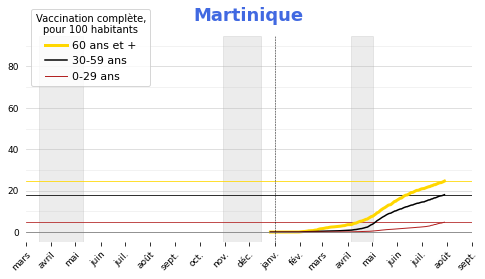

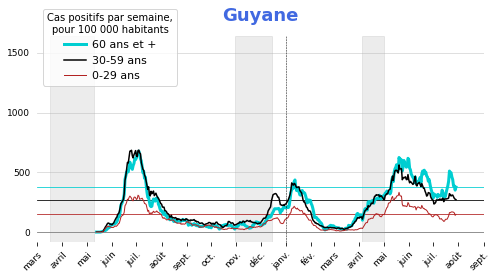

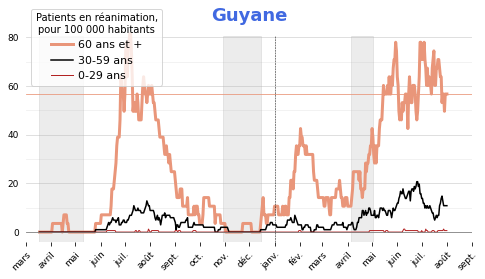

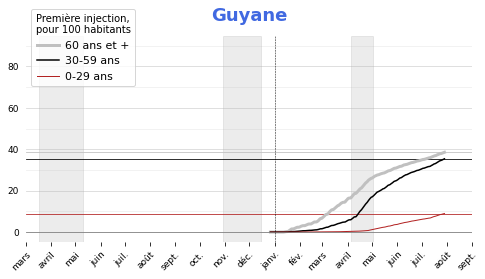

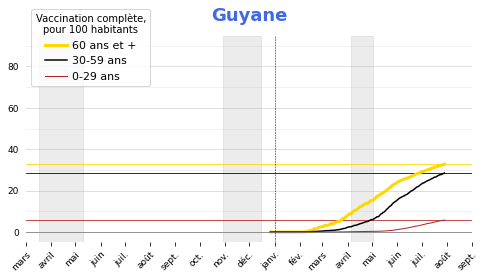

In [52]:
entities = ['Martinique', 'Guyane']
labels = ['incidence hebdo','taux rea', 'taux dose 1', 'taux complet',]
graph_options_alt_drom = go.scale_graph_by_age_class(df,regions_outre_mer, 
                         ('incidence hebdo', '0-29'),
                         ('taux de tests hebdo', '0-29'),
                         ('taux hosp', '60+'),
                         ('taux rea', '60+'),
                         ('taux décès', '60+'),
                        )
graph_options = graph_options_alt_drom

for entity in entities:
    for label in labels:
        gf.simple_figure(df, entity, label, graph_options = graph_options)
        
toc = time()
time_graph = -tic + toc

In [53]:
regions_metro

['Auvergne-Rhône-Alpes',
 'Bourgogne-Franche-Comté',
 'Bretagne',
 'Centre-Val de Loire',
 'Corse',
 'Grand Est',
 'Hauts-de-France',
 'Île-de-France',
 'Normandie',
 'Nouvelle-Aquitaine',
 'Occitanie',
 'Pays de la Loire',
 "Provence-Alpes-Côte d'Azur"]

In [54]:
graph_options['taux rea']['ymax']= 20
graph_options['taux rea']['majloc'], graph_options['taux rea']['minloc']= go.loc_auto(20)
# graph_options['taux rea']['ymax']= 20



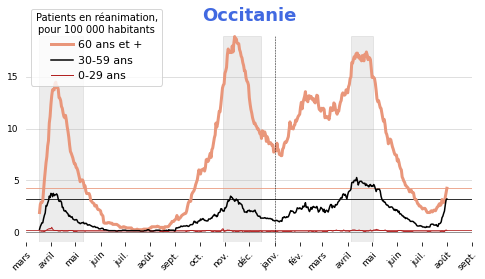

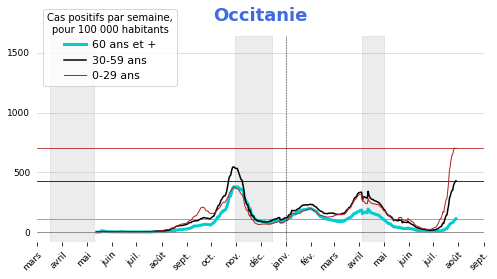

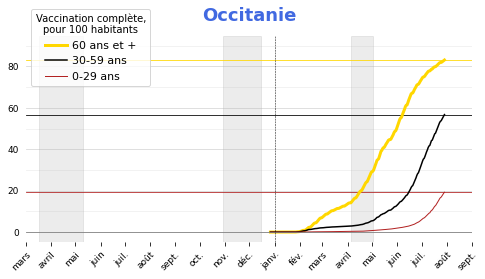

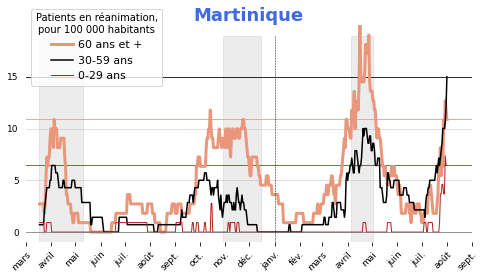

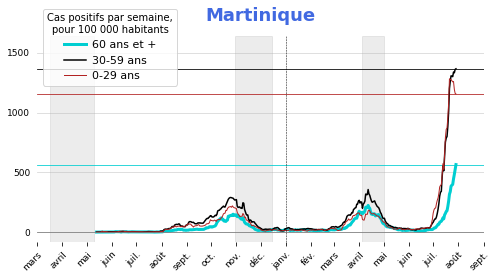

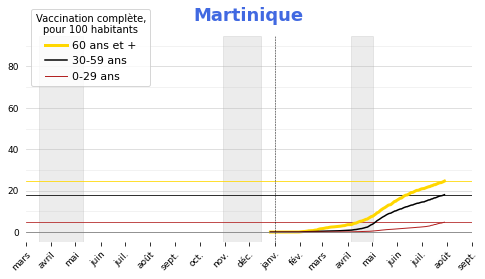

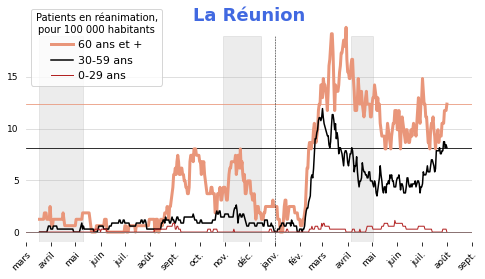

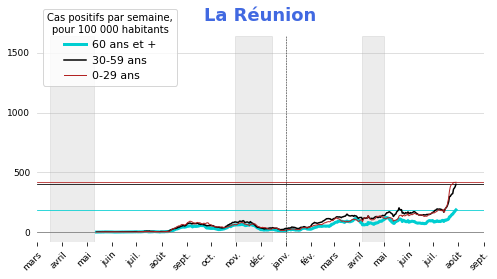

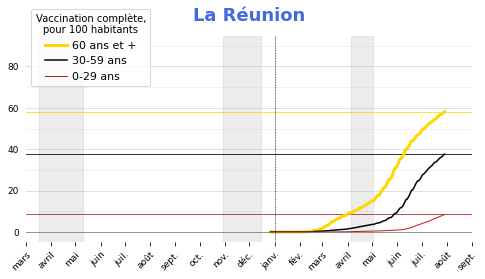

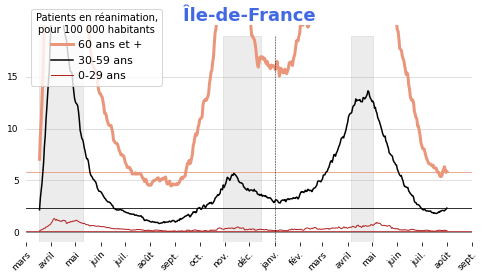

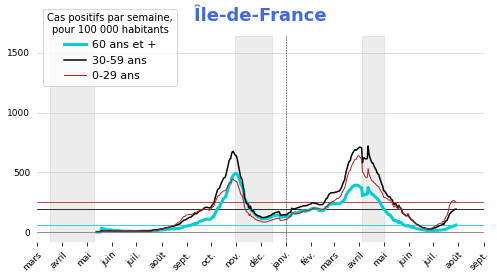

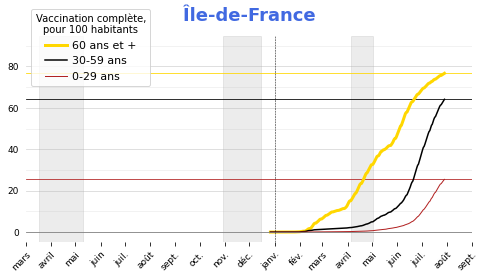

In [55]:
for entity in ['Occitanie', 'Martinique', 'La Réunion', 'Île-de-France']:
    for label in ['taux rea','incidence hebdo', 'taux complet']:
        gf.simple_figure(df, entity, label, graph_options = graph_options, hline = ['0-29', '30-59', '60+'])

In [56]:
d = df.loc[(df.entity == 'France') & (df.three_class == '0-29'), df.dtypes != 'object']

In [57]:
d.loc[:,d.dtypes != 'object']

jour  taux hosp  taux rea  taux décès  taux dose 1  taux complet  \
36144 2020-03-18   0.381736  0.063623         NaN          NaN           NaN   
36148 2020-03-19   0.458084  0.080589         NaN          NaN           NaN   
36152 2020-03-20   0.530189  0.080589         NaN          NaN           NaN   
36156 2020-03-21   0.555639  0.101796         NaN          NaN           NaN   
36160 2020-03-22   0.678642  0.097555         NaN          NaN           NaN   
...          ...        ...       ...         ...          ...           ...   
38132 2021-07-28   1.140968  0.114521         0.0    32.266175     20.653042   
38136 2021-07-29   1.149451  0.144212         0.0    33.107128     21.184279   
38140 2021-07-30   1.183383  0.182385         0.0          NaN           NaN   
38144 2021-07-31   1.272455  0.195110         0.0          NaN           NaN   
38148 2021-08-01   1.378493  0.195110         0.0          NaN           NaN   

       population  incidence hebdo  taux de positifs hebdo  \
36144         NaN              NaN                     NaN   
36148         NaN              NaN                     NaN   
36152         NaN              NaN                     NaN   
36156         NaN              NaN                     NaN   
36160         NaN              NaN                     NaN   
...           ...              ...                     ...   
38132  23555651.0       333.643931                5.073453   
38136  23555651.0       334.577890                4.963707   
38140         NaN              NaN                     NaN   
38144         NaN              NaN                     NaN   
38148         NaN              NaN                     NaN   

       taux de tests hebdo  
36144                  NaN  
36148                  NaN  
36152                  NaN  
36156                  NaN  
36160                  NaN  
...                    ...  
38132          6576.269108  
38136          6740.484481  
38140                  NaN  
38144                  NaN  
38148                  NaN  

[502 rows x 10 columns]

In [58]:
d

jour  taux hosp  taux rea  taux décès  taux dose 1  taux complet  \
36144 2020-03-18   0.381736  0.063623         NaN          NaN           NaN   
36148 2020-03-19   0.458084  0.080589         NaN          NaN           NaN   
36152 2020-03-20   0.530189  0.080589         NaN          NaN           NaN   
36156 2020-03-21   0.555639  0.101796         NaN          NaN           NaN   
36160 2020-03-22   0.678642  0.097555         NaN          NaN           NaN   
...          ...        ...       ...         ...          ...           ...   
38132 2021-07-28   1.140968  0.114521         0.0    32.266175     20.653042   
38136 2021-07-29   1.149451  0.144212         0.0    33.107128     21.184279   
38140 2021-07-30   1.183383  0.182385         0.0          NaN           NaN   
38144 2021-07-31   1.272455  0.195110         0.0          NaN           NaN   
38148 2021-08-01   1.378493  0.195110         0.0          NaN           NaN   

       population  incidence hebdo  taux de positifs hebdo  \
36144         NaN              NaN                     NaN   
36148         NaN              NaN                     NaN   
36152         NaN              NaN                     NaN   
36156         NaN              NaN                     NaN   
36160         NaN              NaN                     NaN   
...           ...              ...                     ...   
38132  23555651.0       333.643931                5.073453   
38136  23555651.0       334.577890                4.963707   
38140         NaN              NaN                     NaN   
38144         NaN              NaN                     NaN   
38148         NaN              NaN                     NaN   

       taux de tests hebdo  
36144                  NaN  
36148                  NaN  
36152                  NaN  
36156                  NaN  
36160                  NaN  
...                    ...  
38132          6576.269108  
38136          6740.484481  
38140                  NaN  
38144                  NaN  
38148                  NaN  

[502 rows x 10 columns]

In [59]:
d.shift(1)

jour  taux hosp  taux rea  taux décès  taux dose 1  taux complet  \
36144        NaT        NaN       NaN         NaN          NaN           NaN   
36148 2020-03-18   0.381736  0.063623         NaN          NaN           NaN   
36152 2020-03-19   0.458084  0.080589         NaN          NaN           NaN   
36156 2020-03-20   0.530189  0.080589         NaN          NaN           NaN   
36160 2020-03-21   0.555639  0.101796         NaN          NaN           NaN   
...          ...        ...       ...         ...          ...           ...   
38132 2021-07-27   1.081586  0.118762         0.0    31.467506     20.069201   
38136 2021-07-28   1.140968  0.114521         0.0    32.266175     20.653042   
38140 2021-07-29   1.149451  0.144212         0.0    33.107128     21.184279   
38144 2021-07-30   1.183383  0.182385         0.0          NaN           NaN   
38148 2021-07-31   1.272455  0.195110         0.0          NaN           NaN   

       population  incidence hebdo  taux de positifs hebdo  \
36144         NaN              NaN                     NaN   
36148         NaN              NaN                     NaN   
36152         NaN              NaN                     NaN   
36156         NaN              NaN                     NaN   
36160         NaN              NaN                     NaN   
...           ...              ...                     ...   
38132  23555651.0       336.624108                5.116214   
38136  23555651.0       333.643931                5.073453   
38140  23555651.0       334.577890                4.963707   
38144         NaN              NaN                     NaN   
38148         NaN              NaN                     NaN   

       taux de tests hebdo  
36144                  NaN  
36148                  NaN  
36152                  NaN  
36156                  NaN  
36160                  NaN  
...                    ...  
38132          6579.554944  
38136          6576.269108  
38140          6740.484481  
38144                  NaN  
38148                  NaN  

[502 rows x 10 columns]

In [60]:
(d.shift(7)['jour']-d['jour']).unique()

array([           'NaT', -604800000000000], dtype='timedelta64[ns]')

In [61]:
d.shift(7)['taux décès']/d['incidence hebdo']

36144         NaN
36148         NaN
36152         NaN
36156         NaN
36160         NaN
           ...   
38132    0.000013
38136    0.000013
38140         NaN
38144         NaN
38148         NaN
Length: 502, dtype: float64

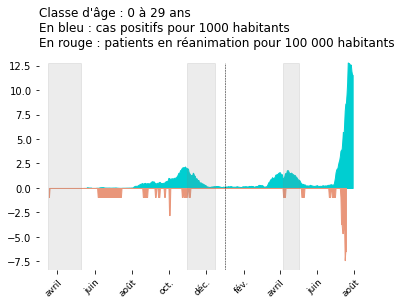

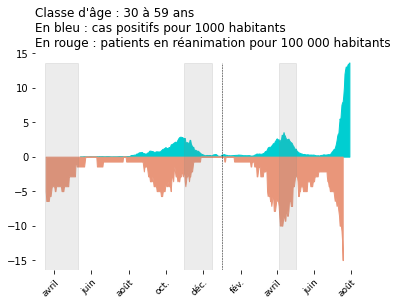

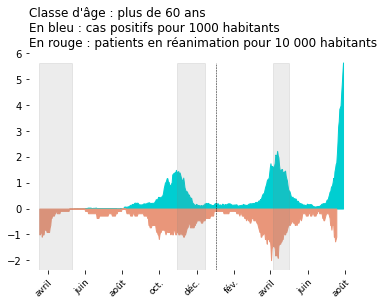

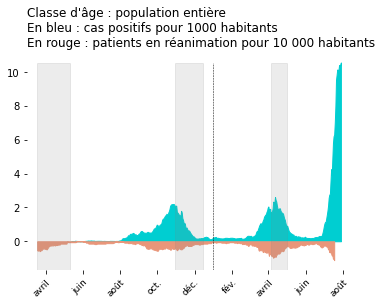

In [62]:
%matplotlib inline
age_class_dict =dict(zip(['0-29', '30-59', '60+', 'whole'], ['0 à 29 ans', '30 à 59 ans', 'plus de 60 ans', 'population entière']))
for age_class, coeff in zip(['0-29', '30-59', '60+', 'whole'], [-100, -100, -10, -10]):
    d = df[(df.entity == 'Martinique') & (df.three_class == age_class)]
    fig, ax = plt.subplots()
    s=ax.spines['top'].set_visible(False)
    s=ax.spines['right'].set_visible(False)
    s=ax.spines['bottom'].set_visible(False)
    s=ax.spines['left'].set_visible(False)
    s=ax.set_xlim(dt.datetime(2020, 3, 1), 
                    dt.datetime(2021, 9, 1))
    s=ax.axvline(dt.datetime(2021, 1, 1), 
                    ymin = 0, ymax = .95, 
                    c = 'black', linewidth = 0.5, linestyle = '--')
    s=ax.axvspan(dt.datetime(2020, 3, 17), 
                    dt.datetime(2020, 5, 10),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    s=ax.axvspan(dt.datetime(2020, 10, 30), 
                    dt.datetime(2020, 12, 15),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    s=ax.axvspan(dt.datetime(2021, 4, 5), 
                    dt.datetime(2021, 5, 2),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    incidence_to_plot = d['incidence hebdo']/100
    s = ax.fill_between(d.jour, incidence_to_plot, color = 'darkturquoise')
#     rea_to_plot = d['taux rea']*coeff/100
#     s = ax.fill_between(d.jour - pd.Timedelta(14,'D'), rea_to_plot, color = 'darksalmon')
    rea_to_plot = d.shift(-14)['taux rea']*coeff/100
    s = ax.fill_between(d.jour, rea_to_plot, color = 'darksalmon')
#     ratio_to_plot = - rea_to_plot/incidence_to_plot
#     s = ax.plot(d.jour, ratio_to_plot)
    s = ax.xaxis.set_tick_params(bottom = True, labelsize = 9)
    xloc = []
    for i in range(9):
        xloc.append(dt.datetime(2020, 4  + 2*i, 1) if 2*i <= 8
                        else dt.datetime(2021, 2*i - 8, 1)
                   )
    labels = ['avril', 'juin', 
                'août', 'oct.', 'déc.', 
                'fév.', 'avril', 
                  'juin','août']
    s=ax.xaxis.set_ticks(xloc)
    s=ax.xaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
    age_class_txt = age_class_dict[age_class]
    rate_specifier = f'{-1000 * coeff:0,d}'.replace(',', ' ')
    s=plt.title(f'Classe d\'âge : {age_class_txt}\nEn bleu : cas positifs pour 1000 habitants\nEn rouge : patients en réanimation pour {rate_specifier} habitants', loc = 'left')

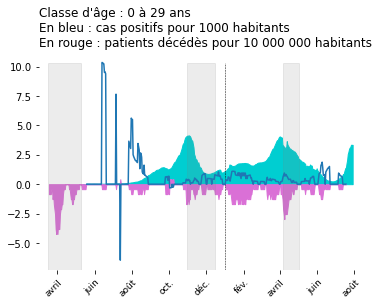

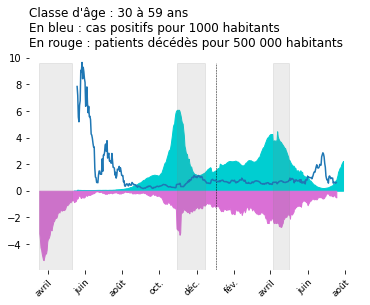

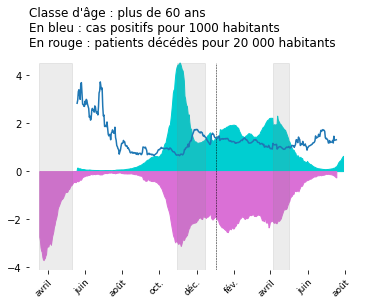

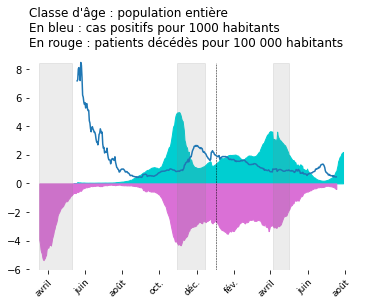

In [63]:
%matplotlib inline
for age_class, coeff in zip(['0-29', '30-59', '60+', 'whole'], [-10000, -500, -20, -100]):
    d = df[(df.entity == 'France') & (df.three_class == age_class)]
    fig, ax = plt.subplots()
    s=ax.spines['top'].set_visible(False)
    s=ax.spines['right'].set_visible(False)
    s=ax.spines['bottom'].set_visible(False)
    s=ax.spines['left'].set_visible(False)
    s=ax.set_xlim(dt.datetime(2020, 3, 1), 
                    dt.datetime(2021, 9, 1))
    s=ax.axvline(dt.datetime(2021, 1, 1), 
                    ymin = 0, ymax = .95, 
                    c = 'black', linewidth = 0.5, linestyle = '--')
    s=ax.axvspan(dt.datetime(2020, 3, 17), 
                    dt.datetime(2020, 5, 10),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    s=ax.axvspan(dt.datetime(2020, 10, 30), 
                    dt.datetime(2020, 12, 15),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    s=ax.axvspan(dt.datetime(2021, 4, 5), 
                    dt.datetime(2021, 5, 2),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
#     s=ax.fill_between(d.jour, d['incidence hebdo']/100, color = 'darkturquoise')
#     s=ax.fill_between(d.jour - pd.Timedelta(14,'D'), d['taux décès']*coeff/100, color = 'orchid')
    
    incidence_to_plot = d['incidence hebdo']/100
    s = ax.fill_between(d.jour, incidence_to_plot, color = 'darkturquoise')
    dc_to_plot = d.shift(-14)['taux décès']*coeff/100
    s = ax.fill_between(d.jour, dc_to_plot, color = 'orchid')
    ratio_to_plot = - dc_to_plot/incidence_to_plot
    s = ax.plot(d.jour, ratio_to_plot)
    s=ax.xaxis.set_tick_params(bottom = True, labelsize = 9)
    xloc = []
    for i in range(9):
        xloc.append(dt.datetime(2020, 4  + 2*i, 1) if 2*i <= 8
                        else dt.datetime(2021, 2*i - 8, 1)
                   )
    labels = ['avril', 'juin', 
                'août', 'oct.', 'déc.', 
                'fév.', 'avril', 
                  'juin','août']
    s=ax.xaxis.set_ticks(xloc)
    s=ax.xaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
    age_class_txt = age_class_dict[age_class]
    rate_specifier = f'{-1000 * coeff:0,d}'.replace(',', ' ')
    s=plt.title(f'Classe d\'âge : {age_class_txt}\nEn bleu : cas positifs pour 1000 habitants\nEn rouge : patients décédès pour {rate_specifier} habitants', loc = 'left')